# Summary

dataset from https://www.kaggle.com/competitions/playground-series-s4e8/data

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import optuna

/opt/anaconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


# Initial data checks
1. Check column names and datatypes.
2. Check nulls.
3. Check cardinality of categorical features.
4. Check distribution of target col.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [4]:
df.isnull().any()

id                      False
class                   False
cap-diameter             True
cap-shape                True
cap-surface              True
cap-color                True
does-bruise-or-bleed     True
gill-attachment          True
gill-spacing             True
gill-color               True
stem-height             False
stem-width              False
stem-root                True
stem-surface             True
stem-color               True
veil-type                True
veil-color               True
has-ring                 True
ring-type                True
spore-print-color        True
habitat                  True
season                  False
dtype: bool

p has slightly more samples than e.

<Axes: ylabel='class'>

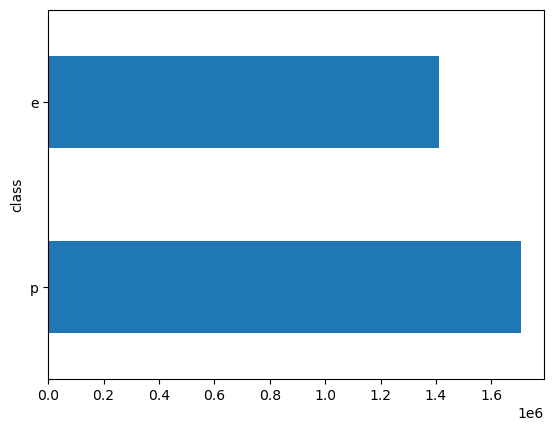

In [5]:
df['class'].value_counts().plot(kind='barh')

# Train

In [6]:
X = df.drop('class', axis=1)
y = pd.DataFrame(df['class'])

cat_cols = list(X.dtypes[X.dtypes=='object'].keys())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=0)
X_train[cat_cols] = X_train[cat_cols].apply(lambda col: col.astype('category'))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda col: col.astype('category'))

sample_row = X.iloc[0, :].to_dict()

In [7]:
model = LGBMClassifier()
model.fit(X_train, y_train)
# model.fit(X_train, y_train, categorical_feature=cat_cols)
preds = model.predict(X_valid)
print(f'score: {accuracy_score(y_valid, preds)}')

/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1194023, number of negative: 987838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547250 -> initscore=0.189565
[LightGBM] [Info] Start training from score 0.189565
score: 0.9903538077862524


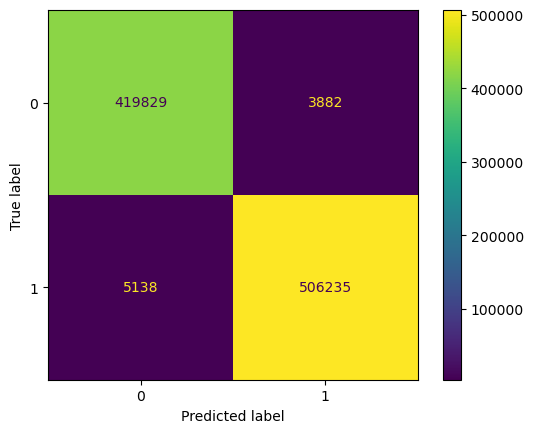

In [12]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

# Optuna

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    clf = LGBMClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

n_estimators = study.best_trial.params['n_estimators']
model = LGBMClassifier(n_estimators=n_estimators)
model.fit(X_train, y_train)



[I 2024-10-27 20:00:44,585] A new study created in memory with name: no-name-fbad7018-9302-46ea-ae89-ccd96e3213cf
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1194023, number of negative: 987838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547250 -> initscore=0.189565
[LightGBM] [Info] Start training from score 0.189565


[I 2024-10-27 20:01:15,129] Trial 0 finished with value: 0.991734432414628 and parameters: {'n_estimators': 329}. Best is trial 0 with value: 0.991734432414628.
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1194023, number of negative: 987838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547250 -> initscore=0.189565
[LightGBM] [Info] Start training from score 0.189565


[I 2024-10-27 20:01:39,823] Trial 1 finished with value: 0.9914521048376402 and parameters: {'n_estimators': 204}. Best is trial 0 with value: 0.991734432414628.
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1194023, number of negative: 987838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547250 -> initscore=0.189565
[LightGBM] [Info] Start training from score 0.189565


[I 2024-10-27 20:01:59,731] Trial 2 finished with value: 0.9911376945814494 and parameters: {'n_estimators': 138}. Best is trial 0 with value: 0.991734432414628.
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1194023, number of negative: 987838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547250 -> initscore=0.189565
[LightGBM] [Info] Start training from score 0.189565


LGBMClassifier(n_estimators=329)

In [26]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [27]:
from pydantic import BaseModel, Field, ValidationError

class Mushroom(BaseModel):
    id: int
    cap_diameter: float = Field(..., alias='cap-diameter')
    cap_shape: object = Field(..., alias='cap-shape')
    cap_surface: object = Field(..., alias='cap-surface')
    cap_color: object = Field(..., alias='cap-color')
    does_bruise_or_bleed: object = Field(..., alias='does-bruise-or-bleed')
    gill_attachment: object = Field(..., alias='gill-attachment')
    gill_spacing: object = Field(..., alias='gill-spacing')
    gill_color: object = Field(..., alias='gill-color')
    stem_height: float = Field(..., alias='stem-height')
    stem_width: float = Field(..., alias='stem-width')
    stem_root: object = Field(..., alias='stem-root')
    stem_surface: object = Field(..., alias='stem-surface')
    stem_color: object = Field(..., alias='stem-color')
    veil_type: object = Field(..., alias='veil-type')
    veil_color: object = Field(..., alias='veil-color')
    has_ring: object = Field(..., alias='has-ring')
    ring_type: object = Field(..., alias='ring-type')
    spore_print_color: object = Field(..., alias='spore-print-color')
    habitat: object
    season: object

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print(sample_row)
mushroom = Mushroom(**sample_row)
inputs = pd.DataFrame([mushroom.model_dump(by_alias=True)])
inputs[cat_cols] = inputs[cat_cols].apply(lambda col: col.astype('category'))
pred = loaded_model.predict(inputs)[0]
pred


{'id': 0, 'cap-diameter': 8.8, 'cap-shape': 'f', 'cap-surface': 's', 'cap-color': 'u', 'does-bruise-or-bleed': 'f', 'gill-attachment': 'a', 'gill-spacing': 'c', 'gill-color': 'w', 'stem-height': 4.51, 'stem-width': 15.39, 'stem-root': nan, 'stem-surface': nan, 'stem-color': 'w', 'veil-type': nan, 'veil-color': nan, 'has-ring': 'f', 'ring-type': 'f', 'spore-print-color': nan, 'habitat': 'd', 'season': 'a'}


'e'

In [22]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        mushroom = Mushroom(**request.json)
        inputs = pd.DataFrame([mushroom.model_dump(by_alias=True)])
        inputs[cat_cols] = inputs[cat_cols].apply(lambda col: col.astype('category'))
        pred = loaded_model.predict(inputs)[0]
        response = {
            'prediction': pred
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [12/Oct/2024 19:51:55] "POST /predict HTTP/1.1" 200 -
